<a href="https://colab.research.google.com/github/Bilal3099/Transfer-Learning/blob/main/Inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import scipy
import numpy as np
from tqdm import tqdm
from random import shuffle
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models
from sklearn import metrics

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import  Dropout,Dense,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from tensorflow.keras.preprocessing import image
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

In [ ]:
from tensorflow.keras.applications import InceptionV3
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
input_path = '/content/drive/MyDrive/archive/chest_xray/'
train_ds_path = input_path + 'train'
test_ds_path = input_path + 'test'
val_ds_path = input_path + 'val'


img_size = 224
batch_size = 32

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   shear_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)


train_batch = train_datagen.flow_from_directory(
              train_ds_path,
              target_size = (img_size, img_size),
              batch_size = batch_size,
              shuffle=True,
              class_mode = 'binary'
)


val_batch = val_datagen.flow_from_directory(
            val_ds_path,
            target_size = (img_size, img_size),
            batch_size = batch_size,
            shuffle=False,
            class_mode = 'binary'
)

test_batch = test_datagen.flow_from_directory(
             test_ds_path,
             target_size = (img_size, img_size),
             batch_size = batch_size,
             shuffle=False,
             class_mode = 'binary'
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


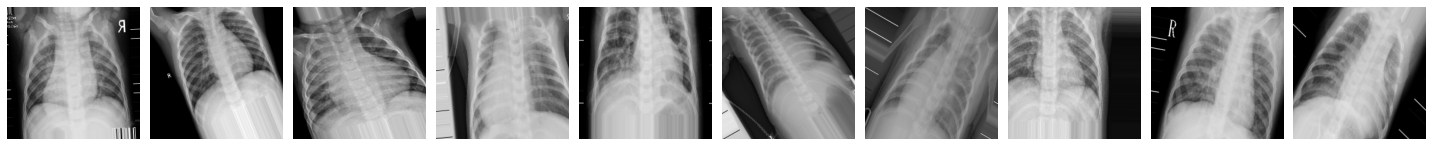

[1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 0. 1.]


In [ ]:
imgs, label = next(train_batch)

def plotImages(images_arr):
  fig, axes = plt.subplots(1, 10, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip (images_arr, axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()  


plotImages(imgs)
print(label)

In [ ]:
def build_model(backbone, learning_rate=1e-4):
  model = Sequential()
  model.add(backbone)
  model.add(layers.GlobalAveragePooling2D())
  model.add(layers.Dropout(0.5))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=learning_rate),
        metrics=['acc']
                  
    )
  return model

incep = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

model = build_model(incep, learning_rate=1e-4)
model.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 batch_normalization_94 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                         

In [ ]:
history = model.fit(
    train_batch,
    steps_per_epoch=163,
    epochs=15,
    validation_data=test_batch,
    validation_steps=20
)

Epoch 1/15
163/163 [==============================] - 697s 4s/step - loss: 0.3142 - acc: 0.8834 - val_loss: 0.5054 - val_acc: 0.8045
Epoch 2/15
163/163 [==============================] - 127s 779ms/step - loss: 0.1746 - acc: 0.9450 - val_loss: 0.5180 - val_acc: 0.8317
Epoch 3/15
163/163 [==============================] - 125s 767ms/step - loss: 0.1271 - acc: 0.9582 - val_loss: 0.2660 - val_acc: 0.8942
Epoch 4/15
163/163 [==============================] - 126s 773ms/step - loss: 0.1039 - acc: 0.9668 - val_loss: 0.3037 - val_acc: 0.9038
Epoch 5/15
163/163 [==============================] - 125s 763ms/step - loss: 0.0685 - acc: 0.9747 - val_loss: 0.2987 - val_acc: 0.8942
Epoch 6/15
163/163 [==============================] - 125s 763ms/step - loss: 0.0713 - acc: 0.9766 - val_loss: 3.2970 - val_acc: 0.8670
Epoch 7/15
163/163 [==============================] - 123s 754ms/step - loss: 0.0633 - acc: 0.9780 - val_loss: 0.2853 - val_acc: 0.8974
Epoch 8/15
163/163 [==============================]

In [ ]:
model.save('InceptionV3.h5')

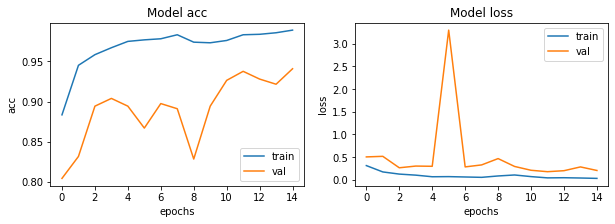

In [ ]:
ig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
pred = model.predict(val_batch)

1/1 [==============================] - 1s 1s/step


In [ ]:
pred

array([[5.6444317e-02],
       [3.4033764e-02],
       [3.4964776e-01],
       [4.8260160e-02],
       [6.9299378e-02],
       [8.7682498e-01],
       [4.6739564e-03],
       [8.9458858e-09],
       [9.9880075e-01],
       [9.9679714e-01],
       [9.4906652e-01],
       [9.9837291e-01],
       [9.8957306e-01],
       [9.9505770e-01],
       [9.8402309e-01],
       [9.9740040e-01]], dtype=float32)

In [ ]:
y_pred = []
for prob in pred:
    if prob >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)


In [ ]:
y_pred

[0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]

In [ ]:
y_true=val_batch.classes

In [ ]:
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
cm = confusion_matrix(y_true, y_pred)

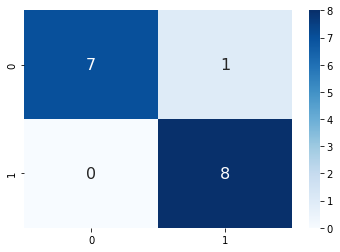

In [ ]:
import seaborn as sn
sn.heatmap(cm, annot=True,cmap="Blues", annot_kws={"size": 16})

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.89      1.00      0.94         8

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.94      0.94      0.94        16



ROC:  0.9375


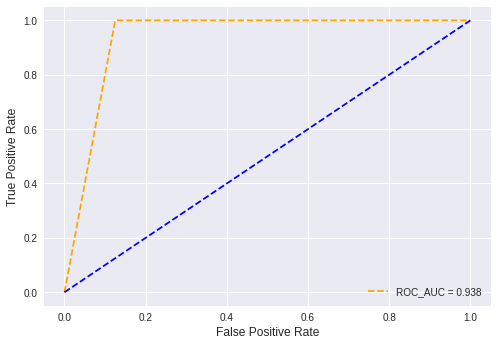

In [ ]:
roc_auc = metrics.roc_auc_score(y_true, y_pred)
print('ROC: ', roc_auc)

random_probs = [0 for i in range(len(y_true))]
p_fpr, t_fpr, thresholds = metrics.roc_curve(y_true, random_probs)
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)

plt.style.use('seaborn')
plt.plot(fpr, tpr, linestyle = '--', color='orange', label='ROC_AUC = %0.3f' % roc_auc)
plt.plot(p_fpr, t_fpr, linestyle = '--', color = 'blue')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc = 'lower right')

plt.show()


In [ ]:
def predict_image(model, img_path, img_dims = 150):
    img = image.load_img(img_path, target_size = (img_dims, img_dims))
    plt.imshow(img)
    plt.show()
    img = image.img_to_array(img)
    x = np.expand_dims(img, axis=0) * 1./255
    score = model.predict(x)
    print('Predictions: ', score, 'NORMAL' if score < 0.5 else 'PNEUMONIA')

In [ ]:
predict_image(model,(val_ds_path + '/NORMAL/NORMAL2-IM-1427-0001.jpeg'))
predict_image(model,(val_ds_path + '/NORMAL/NORMAL2-IM-1430-0001.jpeg'))
predict_image(model,(val_ds_path + '/PNEUMONIA/person1946_bacteria_4874.jpeg'))
predict_image(model,(val_ds_path + '/PNEUMONIA/person1946_bacteria_4875.jpeg'))
predict_image(model,(val_ds_path + '/PNEUMONIA/person1947_bacteria_4876.jpeg'))
predict_image(model,(val_ds_path + '/NORMAL/NORMAL2-IM-1431-0001.jpeg'))
predict_image(model,(val_ds_path + '/PNEUMONIA/person1949_bacteria_4880.jpeg'))
predict_image(model,(val_ds_path + '/NORMAL/NORMAL2-IM-1436-0001.jpeg'))
predict_image(model,(val_ds_path + '/PNEUMONIA/person1952_bacteria_4883.jpeg'))
predict_image(model,(val_ds_path + '/NORMAL/NORMAL2-IM-1442-0001.jpeg'))
predict_image(model,(val_ds_path + '/NORMAL/NORMAL2-IM-1438-0001.jpeg'))
predict_image(model,(val_ds_path + '//PNEUMONIA/person1950_bacteria_4881.jpeg'))